<h1><b><center>MACHINE LEARNING FINAL PROJECT</center></b></h1>

<h2><b><center> Project Name:MultiClass Classification for Breast Cancer Gene Metastasis </center></b></h2>
<h3><b><center> FAISAL RIAZ      [f2019313020@umt.edu.pk]</center></b></h3>
<h3><b><center> NAUMAN ANWAR     [f2019313009@umt.edu.pk]</center></b></h3>
<h3><b><center> TALHA RASOOL     [f2019313039@umt.edu.pk]</center></b></h3>

### Import Key Packages###

In [1]:
import GEOparse
import pandas as pd
import pylab as pl
import seaborn as sns
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 
from sklearn.impute import KNNImputer
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

### Parsing GSE14020 Dataset Platform[GPL96,GPL570]###

In [2]:
gse = GEOparse.get_GEO("GSE14020")

08-Jul-2020 02:08:20 DEBUG utils - Directory ./ already exists. Skipping.
08-Jul-2020 02:08:20 INFO GEOparse - File already exist: using local version.
08-Jul-2020 02:08:20 INFO GEOparse - Parsing ./GSE14020_family.soft.gz: 
08-Jul-2020 02:08:20 DEBUG GEOparse - DATABASE: GeoMiame
08-Jul-2020 02:08:20 DEBUG GEOparse - SERIES: GSE14020
08-Jul-2020 02:08:20 DEBUG GEOparse - PLATFORM: GPL96
08-Jul-2020 02:08:21 DEBUG GEOparse - PLATFORM: GPL570
08-Jul-2020 02:08:24 DEBUG GEOparse - SAMPLE: GSM352095
08-Jul-2020 02:08:24 DEBUG GEOparse - SAMPLE: GSM352097
08-Jul-2020 02:08:24 DEBUG GEOparse - SAMPLE: GSM352098
08-Jul-2020 02:08:24 DEBUG GEOparse - SAMPLE: GSM352100
08-Jul-2020 02:08:24 DEBUG GEOparse - SAMPLE: GSM352101
08-Jul-2020 02:08:24 DEBUG GEOparse - SAMPLE: GSM352103
08-Jul-2020 02:08:24 DEBUG GEOparse - SAMPLE: GSM352105
08-Jul-2020 02:08:25 DEBUG GEOparse - SAMPLE: GSM352107
08-Jul-2020 02:08:25 DEBUG GEOparse - SAMPLE: GSM352109
08-Jul-2020 02:08:25 DEBUG GEOparse - SAMPLE: GSM3

### Analyzing Sample Data 

In [3]:
gse.gpls['GPL570'].columns

description
ID                                Affymetrix Probe Set ID LINK_PRE:"https://www....
GB_ACC                            GenBank Accession Number LINK_PRE:"http://www....
SPOT_ID                                                         identifies controls
Species Scientific Name           The genus and species of the organism represen...
Annotation Date                   The date that the annotations for this probe a...
Sequence Type                                                                      
Sequence Source                   The database from which the sequence used to d...
Target Description                                                                 
Representative Public ID          The accession number of a representative seque...
Gene Title                              Title of Gene represented by the probe set.
Gene Symbol                       A gene symbol, when one is available (from Uni...
ENTREZ_GENE_ID                    Entrez Gene Database UID LINK_PRE:"http://www....
RefSeq Transcript ID              References to multiple sequences in RefSeq. Th...
Gene Ontology Biological Process  Gene Ontology Consortium Biological Process de...
Gene Ontology Cellular Component  Gene Ontology Consortium Cellular Component de...
Gene Ontology Molecular Function  Gene Ontology Consortium Molecular Function de...

In [4]:
gse.gsms["GSM352097"].columns

description
ID_REF            
VALUE   RMA signal

In [5]:
control_samples = ['GSM352097','GSM352100','GSM352136','GSM352138']

### Sample Descriptive Data

In [6]:
pivot_control_samples = gse.pivot_samples('VALUE')[control_samples] # checking the values for control samples only
pivot_control_samples.describe()

name      GSM352097     GSM352100     GSM352136     GSM352138
count  54675.000000  54675.000000  22283.000000  22283.000000
mean       7.155740      7.161875      7.252205      7.266323
std        1.935582      1.977243      1.829973      1.772879
min        3.417845      3.402763      3.927244      3.980609
25%        5.744657      5.702566      5.863900      5.940587
50%        6.958168      6.953594      7.068597      7.125214
75%        8.370800      8.421440      8.373504      8.334107
max       14.962204     14.996596     14.592692     14.650195

In [7]:
pivot_control_samples.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54681 entries, 1007_s_at to AFFX-r2-P1-cre-5_at
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GSM352097  54675 non-null  float64
 1   GSM352100  54675 non-null  float64
 2   GSM352136  22283 non-null  float64
 3   GSM352138  22283 non-null  float64
dtypes: float64(4)
memory usage: 2.1+ MB


In [8]:
pivot_control_samples # ID_REF the gene probes and samples data

name                    GSM352097  GSM352100  GSM352136  GSM352138
ID_REF                                                            
1007_s_at               12.028198  11.589025  10.924860  10.240711
1053_at                  9.478611   8.035468   7.744287   6.946560
117_at                   8.056224  10.979582   7.928543   7.695262
121_at                   9.734242   9.359527   9.167613   9.231827
1255_g_at                4.589639   4.633253   4.800135   6.667909
...                           ...        ...        ...        ...
AFFX-r2-Hs28SrRNA-3_at        NaN        NaN   8.537706   9.970347
AFFX-r2-Hs28SrRNA-5_at        NaN        NaN   5.372566   5.722050
AFFX-r2-Hs28SrRNA-M_at        NaN        NaN   6.740397   7.833424
AFFX-r2-P1-cre-3_at     14.173357  13.966082  13.689355  13.143410
AFFX-r2-P1-cre-5_at     13.999518  13.751962  13.414285  13.010885

[54681 rows x 4 columns]

### Samples Distribution

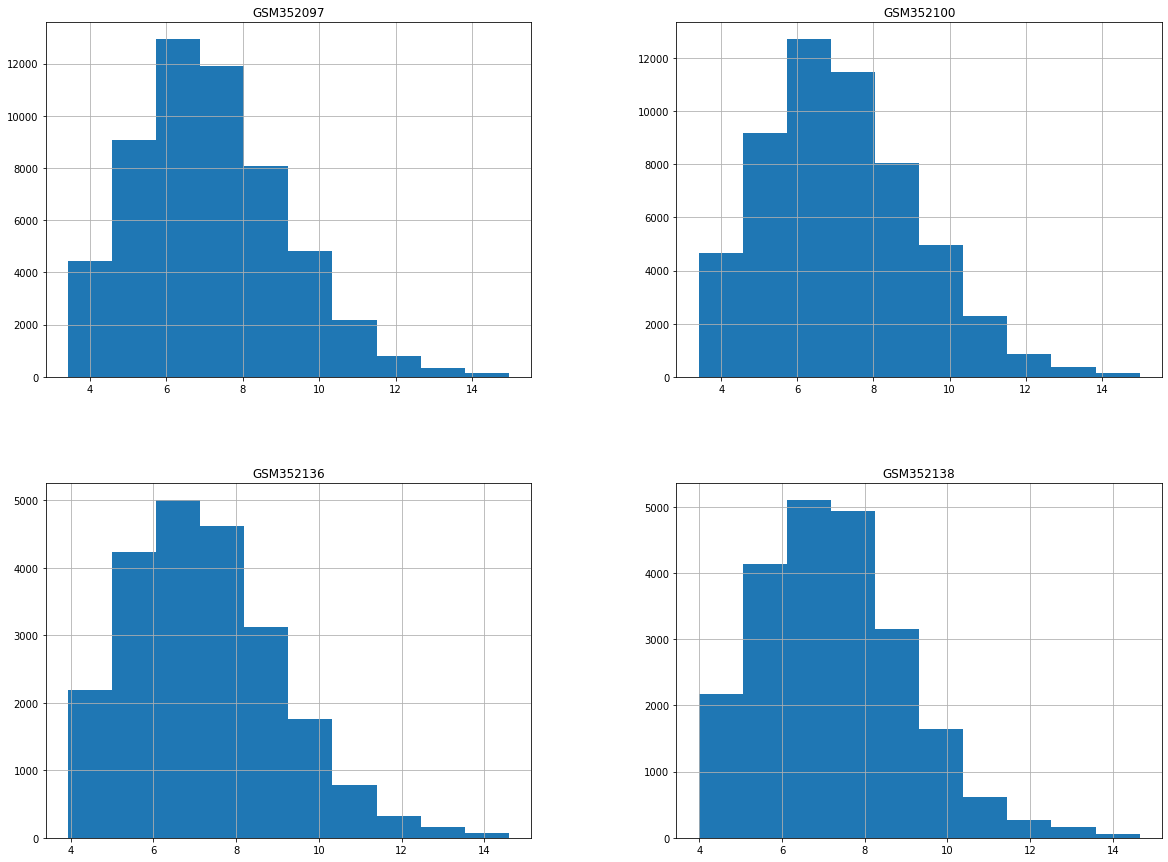

In [9]:
pivot_control_samples.hist(bins=10,figsize=(20,15))
plt.show()

### Parsed Data all 65 Samples

In [10]:
pivot_all_samples = gse.pivot_samples('VALUE')
pivot_all_samples

name                    GSM352095  GSM352097  GSM352098  GSM352100  GSM352101  \
ID_REF                                                                          
1007_s_at               11.942972  12.028198  12.359949  11.589025  11.405878   
1053_at                  9.124514   9.478611   8.936268   8.035468   9.168375   
117_at                   7.832843   8.056224   8.230384  10.979582   7.907716   
121_at                   9.293999   9.734242   9.196800   9.359527   9.449023   
1255_g_at                4.545640   4.589639   4.443698   4.633253   4.698722   
...                           ...        ...        ...        ...        ...   
AFFX-r2-Hs28SrRNA-3_at        NaN        NaN        NaN        NaN        NaN   
AFFX-r2-Hs28SrRNA-5_at        NaN        NaN        NaN        NaN        NaN   
AFFX-r2-Hs28SrRNA-M_at        NaN        NaN        NaN        NaN        NaN   
AFFX-r2-P1-cre-3_at     13.761771  14.173357  14.213187  13.966082  14.098767   
AFFX-r2-P1-cre-5_at     13.626195  13.999518  14.064820  13.751962  13.838414   

name                    GSM352103  GSM352105  GSM352107  GSM352109  GSM352110  \
ID_REF                                                                          
1007_s_at               10.658286  10.835002  12.091930  12.085872  12.344569   
1053_at                  8.102512   9.247241   9.189113   8.306166   9.104509   
117_at                   8.983309   9.381022   7.796607   8.537037   7.934914   
121_at                   9.438934   9.383646   9.080720   9.423481   9.555070   
1255_g_at                4.755724   4.530701   4.644450   4.574697   4.610129   
...                           ...        ...        ...        ...        ...   
AFFX-r2-Hs28SrRNA-3_at        NaN        NaN        NaN        NaN        NaN   
AFFX-r2-Hs28SrRNA-5_at        NaN        NaN        NaN        NaN        NaN   
AFFX-r2-Hs28SrRNA-M_at        NaN        NaN        NaN        NaN        NaN   
AFFX-r2-P1-cre-3_at     14.212548  14.022483  14.092802  13.909739  14.018611   
AFFX-r2-P1-cre-5_at     14.009836  13.765890  13.899300  13.710174  13.746140   

name                    ...  GSM352159  GSM352160  GSM352161  GSM352162  \
ID_REF                  ...                                               
1007_s_at               ...  11.220281  11.122096  10.665713  11.531553   
1053_at                 ...   6.946830   7.232990   6.951289   7.023597   
117_at                  ...   8.465121   7.887310   8.854454   7.617238   
121_at                  ...   9.332640   9.058436   9.196497   9.201497   
1255_g_at               ...   5.060824   5.025135   4.922888   4.965196   
...                     ...        ...        ...        ...        ...   
AFFX-r2-Hs28SrRNA-3_at  ...   8.619765   9.458814   8.210674   8.288067   
AFFX-r2-Hs28SrRNA-5_at  ...   5.310254   5.800877   5.431367   5.118560   
AFFX-r2-Hs28SrRNA-M_at  ...   6.478841   7.287388   6.911227   6.232844   
AFFX-r2-P1-cre-3_at     ...  13.221453  13.074879  13.122119  13.465000   
AFFX-r2-P1-cre-5_at     ...  12.770572  12.701490  12.864686  13.250860   

name                    GSM352163  GSM352164  GSM352165  GSM352166  GSM352167  \
ID_REF                                                                          
1007_s_at               10.615657  10.253499  11.060955  10.999642   9.523839   
1053_at                  7.014296   6.999848   7.609674   6.644695   6.741417   
117_at                   7.877476   7.746652   7.653508   7.794672   8.241767   
121_at                   9.318078   8.943775   9.081481   9.145070   9.340316   
1255_g_at                5.101353   4.862778   4.880778   4.906529   4.975271   
...                           ...        ...        ...        ...        ...   
AFFX-r2-Hs28SrRNA-3_at   9.026519   8.183792   9.115837   7.022862   8.961096   
AFFX-r2-Hs28SrRNA-5_at   5.516623   5.300027   5.365604   5.190738   5.682180   
AFFX-r2-Hs28SrRNA-M_at   6.603773   6.422075   7.347967   6.443151   6.652361   
AFFX-r2-P1-cre-3_at     1

### All Samples Descriptive Data

In [11]:
pivot_all_samples.describe()

name      GSM352095     GSM352097     GSM352098     GSM352100     GSM352101  \
count  54675.000000  54675.000000  54675.000000  54675.000000  54675.000000   
mean       7.167422      7.155740      7.160059      7.161875      7.162138   
std        1.998508      1.935582      1.973653      1.977243      1.960935   
min        3.450862      3.417845      3.464398      3.402763      3.414692   
25%        5.696458      5.744657      5.695420      5.702566      5.716490   
50%        6.937152      6.958168      6.933364      6.953594      6.936070   
75%        8.430704      8.370800      8.455337      8.421440      8.439970   
max       14.856009     14.962204     15.091305     14.996596     15.103639   

name      GSM352103     GSM352105     GSM352107     GSM352109     GSM352110  \
count  54675.000000  54675.000000  54675.000000  54675.000000  54675.000000   
mean       7.162534      7.164306      7.165507      7.170363      7.168232   
std        1.924013      1.970653      1.990743      1.981803      1.950165   
min        3.391527      3.464376      3.453287      3.455291      3.487308   
25%        5.759855      5.709995      5.680854      5.708398      5.748258   
50%        6.968736      6.942801      6.929127      6.947569      6.966047   
75%        8.385725      8.439460      8.479254      8.441586      8.373660   
max       15.096898     15.044271     15.098834     15.032810     15.016911   

name   ...     GSM352159     GSM352160     GSM352161     GSM352162  \
count  ...  22283.000000  22283.000000  22283.000000  22283.000000   
mean   ...      7.279486      7.287015      7.259359      7.265685   
std    ...      1.723618      1.744197      1.762761      1.757369   
min    ...      3.976205      4.004770      3.995594      4.016571   
25%    ...      5.996842      5.986529      5.931989      5.939244   
50%    ...      7.179393      7.178527      7.139446      7.132705   
75%    ...      8.330403      8.353043      8.350502      8.357412   
max    ...     14.594267     14.719422     14.664060     14.694015   

name      GSM352163     GSM352164     GSM352165     GSM352166     GSM352167  \
count  22283.000000  22283.000000  22283.000000  22283.000000  22283.000000   
mean       7.268274      7.274196      7.267751      7.262878      7.256921   
std        1.726048      1.786994      1.785860      1.750822      1.747396   
min        4.027720      3.981980      3.969751      3.988817      3.994735   
25%        6.002618      5.920992      5.931033      5.963616      5.956830   
50%        7.165056      7.134262      7.118474      7.132574      7.125842   
75%        8.288328      8.391304      8.369565      8.323332      8.326578   
max       14.459990     14.556144     14.607074     14.655848     14.776593   

name      GSM352168  
count  22283.000000  
mean       7.236719  
std        1.596998  
min        4.004957  
25%        6.070536  
50%        7.187525  
75%        8.229306  
max       14.763825  

[8 rows x 65 columns]

### Analyzing Phenotype Data to Check sample Metastasis

In [12]:
gse.phenotype_data

title geo_accession  \
GSM352095     5381T (U133plus2): Lung metastasis     GSM352095   
GSM352097  102962T (U133plus2): Brain metastasis     GSM352097   
GSM352098  104406T (U133plus2): Brain metastasis     GSM352098   
GSM352100   105079T (U133plus2): Bone metastasis     GSM352100   
GSM352101  107502T (U133plus2): Brain metastasis     GSM352101   
...                                          ...           ...   
GSM352164         4059T (U133A): Lung metastasis     GSM352164   
GSM352165         5381T (U133A): Lung metastasis     GSM352165   
GSM352166         6565T (U133A): Lung metastasis     GSM352166   
GSM352167         6752T (U133A): Bone metastasis     GSM352167   
GSM352168         7130T (U133A): Lung metastasis     GSM352168   

                          status submission_date last_update_date type  \
GSM352095  Public on May 01 2009     Dec 17 2008      Aug 28 2018  RNA   
GSM352097  Public on May 01 2009     Dec 17 2008      Aug 28 2018  RNA   
GSM352098  Public on May 01 2009     Dec 17 2008      Aug 28 2018  RNA   
GSM352100  Public on May 01 2009     Dec 17 2008      Aug 28 2018  RNA   
GSM352101  Public on May 01 2009     Dec 17 2008      Aug 28 2018  RNA   
...                          ...             ...              ...  ...   
GSM352164  Public on May 01 2009     Dec 17 2008      Dec 17 2008  RNA   
GSM352165  Public on May 01 2009     Dec 17 2008      Dec 17 2008  RNA   
GSM352166  Public on May 01 2009     Dec 17 2008      Dec 17 2008  RNA   
GSM352167  Public on May 01 2009     Dec 17 2008      Dec 17 2008  RNA   
GSM352168  Public on May 01 2009     Dec 17 2008      Dec 17 2008  RNA   

          channel_count source_name_ch1  organism_ch1 taxid_ch1  ...  \
GSM352095             1            Lung  Homo sapiens      9606  ...   
GSM352097             1           Brain  Homo sapiens      9606  ...   
GSM352098             1           Brain  Homo sapiens      9606  ...   
GSM352100             1            Bone  Homo sapiens      9606  ...   
GSM352101             1           Brain  Homo sapiens      9606  ...   
...                 ...             ...           ...       ...  ...   
GSM352164             1            Lung  Homo sapiens      9606  ...   
GSM352165             1            Lung  Homo sapiens      9606  ...   
GSM352166             1            Lung  Homo sapiens      9606  ...   
GSM352167             1            Bone  Homo sapiens      9606  ...   
GSM352168             1            Lung  Homo sapiens      9606  ...   

                    contact_institute           contact_address contact_city  \
GSM352095  Baylor College of Medicine  One Baylor Plaza, BCM600      Houston   
GSM352097  Baylor College of Medicine  One Baylor Plaza, BCM600      Houston   
GSM352098  Baylor College of Medicine  One Baylor Plaza, BCM600      Houston   
GSM352100  Baylor College of Medicine  One Baylor Plaza, BCM600      Houston   
GSM352101  Baylor College of Medicine  One Baylor Plaza, BCM600      Houston   
...                               ...                       ...          ...   
GSM352164  Baylor College of Medicine  One Baylor Plaza, BCM600      Houston   
GSM352165  Baylor College of Medicine  One Baylor Plaza, BCM600      Houston   
GSM352166  Baylor College of Medicine  One Baylor Plaza, BCM600      Houston   
GSM352167  Baylor College of Medicine  One Baylor Plaza, BCM600      Houston   
GSM352168  Baylor College of Medicine  One Baylor Plaza, BCM600      Houston   

          contact_state contact_zip/postal_code contact_country  \
GSM352095            TX                   77030             USA   
GSM352097            TX                   77030             USA   
GSM352098            TX                   77030             USA   
GSM352100            TX                   77030             USA   
GSM352101            TX                   77030             USA   
...                 ...                     ...             ...   
GSM352164            TX                   77030             USA   

### Extracting Metastasis for each sample

In [13]:
metastasis = {}

for i, (idx, row) in enumerate(gse.phenotype_data.iterrows()):
    tmp = {}
    tmp["Sample"] = idx
    tmp["Metastasis"] = re.match(r"(^\w+)", row["source_name_ch1"]).group(1)
    metastasis[i] = tmp
    
metastasis = pd.DataFrame(metastasis).T

print(metastasis)

       Sample Metastasis
0   GSM352095       Lung
1   GSM352097      Brain
2   GSM352098      Brain
3   GSM352100       Bone
4   GSM352101      Brain
..        ...        ...
60  GSM352164       Lung
61  GSM352165       Lung
62  GSM352166       Lung
63  GSM352167       Bone
64  GSM352168       Lung

[65 rows x 2 columns]


### Transformation of Data

In [14]:
# annotate with GPL
samples = pivot_all_samples
# annotate with GPL
lfc_result_annotated = samples.reset_index().merge(gse.gpls['GPL570'].table[["ID", "ENTREZ_GENE_ID"]],
                                left_on='ID_REF', right_on="ID")
lfc_result_annotated

ID_REF  GSM352095  GSM352097  GSM352098  GSM352100  \
0                 1007_s_at  11.942972  12.028198  12.359949  11.589025   
1                   1053_at   9.124514   9.478611   8.936268   8.035468   
2                    117_at   7.832843   8.056224   8.230384  10.979582   
3                    121_at   9.293999   9.734242   9.196800   9.359527   
4                 1255_g_at   4.545640   4.589639   4.443698   4.633253   
...                     ...        ...        ...        ...        ...   
54670  AFFX-r2-Ec-bioC-5_at   9.612546   9.972180  10.476397   9.757595   
54671  AFFX-r2-Ec-bioD-3_at  12.215268  12.794652  12.884326  12.362589   
54672  AFFX-r2-Ec-bioD-5_at  11.681449  12.391372  12.547635  11.959521   
54673   AFFX-r2-P1-cre-3_at  13.761771  14.173357  14.213187  13.966082   
54674   AFFX-r2-P1-cre-5_at  13.626195  13.999518  14.064820  13.751962   

       GSM352101  GSM352103  GSM352105  GSM352107  GSM352109  ...  GSM352161  \
0      11.405878  10.658286  10.835002  12.091930  12.085872  ...  10.665713   
1       9.168375   8.102512   9.247241   9.189113   8.306166  ...   6.951289   
2       7.907716   8.983309   9.381022   7.796607   8.537037  ...   8.854454   
3       9.449023   9.438934   9.383646   9.080720   9.423481  ...   9.196497   
4       4.698722   4.755724   4.530701   4.644450   4.574697  ...   4.922888   
...          ...        ...        ...        ...        ...  ...        ...   
54670   9.926857   9.940444   9.910929  10.090789   9.536221  ...   8.941735   
54671  12.569956  12.680226  12.542622  12.711259  12.223149  ...  11.519984   
54672  12.259550  12.307256  12.066900  12.309828  11.809649  ...  11.443526   
54673  14.098767  14.212548  14.022483  14.092802  13.909739  ...  13.122119   
54674  13.838414  14.009836  13.765890  13.899300  13.710174  ...  12.864686   

       GSM352162  GSM352163  GSM352164  GSM352165  GSM352166  GSM352167  \
0      11.531553  10.615657  10.253499  11.060955  10.999642   9.523839   
1       7.023597   7.014296   6.999848   7.609674   6.644695   6.741417   
2       7.617238   7.877476   7.746652   7.653508   7.794672   8.241767   
3       9.201497   9.318078   8.943775   9.081481   9.145070   9.340316   
4       4.965196   5.101353   4.862778   4.880778   4.906529   4.975271   
...          ...        ...        ...        ...        ...        ...   
54670   9.214054   8.833961   8.859969   8.674369   9.414216   9.496506   
54671  11.186171  11.180722  11.407633  10.689757  11.365112  11.522543   
54672  10.963019  10.944397  11.139901  10.546062  11.293651  11.396987   
54673  13.465000  12.988899  12.896722  12.744409  13.289318  13.437831   
54674  13.250860  12.845894  12.677434  12.748299  13.326638  13.372679   

       GSM352168                    ID     ENTREZ_GENE_ID  
0      10.644172             1007_s_at  780 /// 100616237  
1       6.826809               1053_at               5982  
2       8.210786                117_at               3310  
3       9.089787                121_at               7849  
4       5.329008             1255_g_at               2978  
...          ...                   ...                ...  
54670  10.636157  AFFX-r2-Ec-bioC-5_at                NaN  
54671  12.753672  AFFX-r2-Ec-bioD-3_at                NaN  
54672  12.903440  AFFX-r2-Ec-bioD-5_at                NaN  
54673  13.903414   AFFX-r2-P1-cre-3_at                NaN  
54674  13.804293   AFFX-r2-P1-cre-5_at                NaN  

[54675 rows x 68 columns]

In [15]:
del lfc_result_annotated["ID"]
# remove probes without ENTREZ
lfc_result_annotated = lfc_result_annotated.dropna(subset=["ENTREZ_GENE_ID"])
# remove probes with more than one gene assigned
lfc_result_annotated = lfc_result_annotated[~lfc_result_annotated.ENTREZ_GENE_ID.str.contains("///")]
# for each gene average LFC over probes
#lfc_result_annotated = lfc_result_annotated.groupby("ENTREZ_GENE_ID").median()
lfc_result_annotated = lfc_result_annotated.groupby("ENTREZ_GENE_ID").median()


### ENTREZ_GENE_ID is unique identifier for genes

In [16]:
lfc_result_annotated

GSM352095  GSM352097  GSM352098  GSM352100  GSM352101  \
ENTREZ_GENE_ID                                                          
1                8.233865   6.905281   7.711297   7.377047   7.452669   
10               6.068273   6.849483   7.232890   6.706921   6.899248   
100              7.884826   7.079831   6.549457   7.839208   6.453505   
1000             6.872059   9.168191   7.224291   7.313262  10.030308   
10000            6.692296   6.949101   6.273194   7.132396   6.494785   
...                   ...        ...        ...        ...        ...   
9991             7.943965   7.682004   8.261585   7.646146   7.479994   
9992             6.484914   6.645859   6.566080   6.533492   6.707539   
9993             9.353839   8.753059   9.778583   8.986372   9.068742   
9994             6.573483   7.009143   7.642260   6.850061   7.079372   
9997            10.702294   8.816913  10.869506   9.663946   9.820668   

                GSM352103  GSM352105  GSM352107  GSM352109  GSM352110  ...  \
ENTREZ_GENE_ID                                                         ...   
1                7.452807   7.818692   6.924453   7.376692   6.935478  ...   
10               6.827421   6.693747   6.415657   6.429716   6.845508  ...   
100              6.386633   9.457684   7.185822   7.114903   7.201791  ...   
1000            10.812616  10.781749   7.815578   7.541359   8.058856  ...   
10000            7.197053   6.636456   8.371197   6.655699   6.507909  ...   
...                   ...        ...        ...        ...        ...  ...   
9991             7.372331   7.112737   7.559665   7.406394   9.373819  ...   
9992             6.807198   6.602955   6.373015   6.369504   6.682483  ...   
9993             8.374174   8.405619   8.812024   8.587392   9.014228  ...   
9994             7.335020   7.455209   8.578198   6.991688   7.122896  ...   
9997             9.882025  10.164475  10.559051   9.946459   9.291362  ...   

                GSM352159  GSM352160  GSM352161  GSM352162  GSM352163  \
ENTREZ_GENE_ID                                                          
1                     NaN        NaN        NaN        NaN        NaN   
10               7.108897   6.557304   7.146142   7.666994   6.994919   
100              6.690407   7.513352   6.913681   6.474071   7.486394   
1000             6.778398   6.830518   6.626595   7.045151   6.684408   
10000            5.118221   5.461877   5.080889   5.174071   5.526067   
...                   ...        ...        ...        ...        ...   
9991             7.047683   6.724515   6.563508   6.669139   6.757341   
9992             6.857786   6.801123   7.170083   6.738062   7.006983   
9993             7.488564   7.822422   8.329778   7.560678   7.558973   
9994             6.923275   6.601999   7.225730   7.859687   6.272728   
9997             8.520256   9.030472   9.544084   7.842293   9.015131   

                GSM352164  GSM352165  GSM352166  GSM352167  GSM352168  
ENTREZ_GENE_ID                                                         
1                     NaN        NaN        NaN        NaN        NaN  
10               6.551170   6.544033   6.949674   6.767594   7.488313  
100              7.330556   7.333471   6.691336   7.134458   6.905290  
1000             7.441851   6.687331   6.650636   7.631923   6.851237  
10000            5.427531   5.960973   6.239523   6.552234   5.671638  
...                   ...        ...        ...        ...        ...  
9991             6.287299   6.976204   6.239831   6.583108   6.048680  
9992             6.790321   6.798311   7.036692   6.945865   7.082149  
9993             8.051541   8.160866   7.802814   8.046653   7.714663  
9994             7.111595   6.111306   6.867145   6.389302   6.936976  
9997             8.627509   9.252188   8.466332   8.580610   9.235360  

[20486 rows x 65 columns]

### Tranforming data in X[x1,x2,x3,........Xn][Y] Dataframe 

In [17]:
df = lfc_result_annotated.T.reset_index()
df["Metastasis"] = metastasis["Metastasis"]
df

ENTREZ_GENE_ID      index         1        10       100       1000     10000  \
0               GSM352095  8.233865  6.068273  7.884826   6.872059  6.692296   
1               GSM352097  6.905281  6.849483  7.079831   9.168191  6.949101   
2               GSM352098  7.711297  7.232890  6.549457   7.224291  6.273194   
3               GSM352100  7.377047  6.706921  7.839208   7.313262  7.132396   
4               GSM352101  7.452669  6.899248  6.453505  10.030308  6.494785   
..                    ...       ...       ...       ...        ...       ...   
60              GSM352164       NaN  6.551170  7.330556   7.441851  5.427531   
61              GSM352165       NaN  6.544033  7.333471   6.687331  5.960973   
62              GSM352166       NaN  6.949674  6.691336   6.650636  6.239523   
63              GSM352167       NaN  6.767594  7.134458   7.631923  6.552234   
64              GSM352168       NaN  7.488313  6.905290   6.851237  5.671638   

ENTREZ_GENE_ID  100009676     10001     10002     10003  ...       9988  \
0                5.105685  7.426671  5.360786  3.721369  ...  10.271383   
1                5.314471  7.870653  5.285878  3.901400  ...   9.683429   
2                5.582347  7.891493  5.739833  3.767219  ...   9.536066   
3                5.102163  8.170485  5.485238  3.709746  ...   9.797001   
4                5.164533  8.203668  5.253393  3.774987  ...  10.251537   
..                    ...       ...       ...       ...  ...        ...   
60                    NaN  7.220568  5.481236  4.365592  ...   8.628865   
61                    NaN  6.017666  5.423868  4.331322  ...   8.685351   
62                    NaN  6.037522  5.476068  4.425518  ...   8.609359   
63                    NaN  7.289287  5.417038  4.344127  ...   8.539495   
64                    NaN  6.025582  5.538950  4.441620  ...   8.544075   

ENTREZ_GENE_ID       9989        999      9990      9991      9992      9993  \
0               10.304689   9.266338  5.260572  7.943965  6.484914  9.353839   
1               10.883520   9.675660  6.374570  7.682004  6.645859  8.753059   
2               10.809552  10.552436  5.929682  8.261585  6.566080  9.778583   
3               11.005365  10.024471  5.885538  7.646146  6.533492  8.986372   
4               12.934926  10.035675  5.724105  7.479994  6.707539  9.068742   
..                    ...        ...       ...       ...       ...       ...   
60               9.113422   9.117427  5.866972  6.287299  6.790321  8.051541   
61               9.033139   8.426105  5.656297  6.976204  6.798311  8.160866   
62               8.713727   8.270274  5.906058  6.239831  7.036692  7.802814   
63               9.711532   5.445101  5.923284  6.583108  6.945865  8.046653   
64               9.897884   8.145417  6.562124  6.048680  7.082149  7.714663   

ENTREZ_GENE_ID      9994       9997  Metastasis  
0               6.573483  10.702294        Lung  
1               7.009143   8.816913       Brain  
2               7.642260  10.869506       Brain  
3               6.850061   9.663946        Bone  
4               7.079372   9.820668       Brain  
..                   ...        ...         ...  
60              7.111595   8.627509        Lung  
61              6.111306   9.252188        Lung  
62              6.867145   8.466332        Lung  
63              6.389302   8.580610        Bone  
64              6.936976   9.235360        Lung  

[65 rows x 20488 columns]

### Metastasis Distribution per Class

In [18]:
df['Metastasis'].value_counts()

Brain    22
Lung     20
Bone     18
Liver     5
Name: Metastasis, dtype: int64

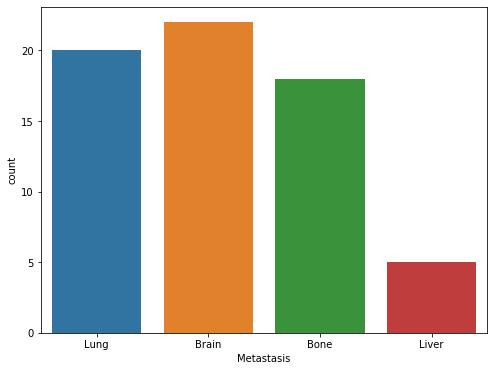

In [19]:
plt.figure(figsize=(8,6))
sns.countplot(df['Metastasis'],label='Class Count')
plt.show()

### Mapping Classes from 0 to 3

In [20]:
df['Metastasis'] = df['Metastasis'].map({'Lung': 0, 'Brain': 1, 'Bone': 2, 'Liver': 3})

In [21]:
df

ENTREZ_GENE_ID      index         1        10       100       1000     10000  \
0               GSM352095  8.233865  6.068273  7.884826   6.872059  6.692296   
1               GSM352097  6.905281  6.849483  7.079831   9.168191  6.949101   
2               GSM352098  7.711297  7.232890  6.549457   7.224291  6.273194   
3               GSM352100  7.377047  6.706921  7.839208   7.313262  7.132396   
4               GSM352101  7.452669  6.899248  6.453505  10.030308  6.494785   
..                    ...       ...       ...       ...        ...       ...   
60              GSM352164       NaN  6.551170  7.330556   7.441851  5.427531   
61              GSM352165       NaN  6.544033  7.333471   6.687331  5.960973   
62              GSM352166       NaN  6.949674  6.691336   6.650636  6.239523   
63              GSM352167       NaN  6.767594  7.134458   7.631923  6.552234   
64              GSM352168       NaN  7.488313  6.905290   6.851237  5.671638   

ENTREZ_GENE_ID  100009676     10001     10002     10003  ...       9988  \
0                5.105685  7.426671  5.360786  3.721369  ...  10.271383   
1                5.314471  7.870653  5.285878  3.901400  ...   9.683429   
2                5.582347  7.891493  5.739833  3.767219  ...   9.536066   
3                5.102163  8.170485  5.485238  3.709746  ...   9.797001   
4                5.164533  8.203668  5.253393  3.774987  ...  10.251537   
..                    ...       ...       ...       ...  ...        ...   
60                    NaN  7.220568  5.481236  4.365592  ...   8.628865   
61                    NaN  6.017666  5.423868  4.331322  ...   8.685351   
62                    NaN  6.037522  5.476068  4.425518  ...   8.609359   
63                    NaN  7.289287  5.417038  4.344127  ...   8.539495   
64                    NaN  6.025582  5.538950  4.441620  ...   8.544075   

ENTREZ_GENE_ID       9989        999      9990      9991      9992      9993  \
0               10.304689   9.266338  5.260572  7.943965  6.484914  9.353839   
1               10.883520   9.675660  6.374570  7.682004  6.645859  8.753059   
2               10.809552  10.552436  5.929682  8.261585  6.566080  9.778583   
3               11.005365  10.024471  5.885538  7.646146  6.533492  8.986372   
4               12.934926  10.035675  5.724105  7.479994  6.707539  9.068742   
..                    ...        ...       ...       ...       ...       ...   
60               9.113422   9.117427  5.866972  6.287299  6.790321  8.051541   
61               9.033139   8.426105  5.656297  6.976204  6.798311  8.160866   
62               8.713727   8.270274  5.906058  6.239831  7.036692  7.802814   
63               9.711532   5.445101  5.923284  6.583108  6.945865  8.046653   
64               9.897884   8.145417  6.562124  6.048680  7.082149  7.714663   

ENTREZ_GENE_ID      9994       9997  Metastasis  
0               6.573483  10.702294           0  
1               7.009143   8.816913           1  
2               7.642260  10.869506           1  
3               6.850061   9.663946           2  
4               7.079372   9.820668           1  
..                   ...        ...         ...  
60              7.111595   8.627509           0  
61              6.111306   9.252188           0  
62              6.867145   8.466332           0  
63              6.389302   8.580610           2  
64              6.936976   9.235360           0  

[65 rows x 20488 columns]

### Extracting X and y from Dataset

In [22]:
X = df.drop(['Metastasis','index'],axis=1) # choosing genes from x1,x2,x3,,,,,,xn
old_col = X.columns # preserving column names
y = df[['Metastasis']] # separating your dependant variable 
X

ENTREZ_GENE_ID         1        10       100       1000     10000  100009676  \
0               8.233865  6.068273  7.884826   6.872059  6.692296   5.105685   
1               6.905281  6.849483  7.079831   9.168191  6.949101   5.314471   
2               7.711297  7.232890  6.549457   7.224291  6.273194   5.582347   
3               7.377047  6.706921  7.839208   7.313262  7.132396   5.102163   
4               7.452669  6.899248  6.453505  10.030308  6.494785   5.164533   
..                   ...       ...       ...        ...       ...        ...   
60                   NaN  6.551170  7.330556   7.441851  5.427531        NaN   
61                   NaN  6.544033  7.333471   6.687331  5.960973        NaN   
62                   NaN  6.949674  6.691336   6.650636  6.239523        NaN   
63                   NaN  6.767594  7.134458   7.631923  6.552234        NaN   
64                   NaN  7.488313  6.905290   6.851237  5.671638        NaN   

ENTREZ_GENE_ID     10001     10002     10003     10004  ...       9987  \
0               7.426671  5.360786  3.721369  6.374178  ...   9.435036   
1               7.870653  5.285878  3.901400  6.907680  ...  10.576191   
2               7.891493  5.739833  3.767219  6.100799  ...   9.986124   
3               8.170485  5.485238  3.709746  6.857081  ...  10.399339   
4               8.203668  5.253393  3.774987  6.137025  ...   9.937045   
..                   ...       ...       ...       ...  ...        ...   
60              7.220568  5.481236  4.365592  5.721392  ...   9.279700   
61              6.017666  5.423868  4.331322  6.083392  ...   8.920797   
62              6.037522  5.476068  4.425518  6.166736  ...   9.591995   
63              7.289287  5.417038  4.344127  5.973485  ...   9.861801   
64              6.025582  5.538950  4.441620  5.937243  ...   8.439654   

ENTREZ_GENE_ID       9988       9989        999      9990      9991      9992  \
0               10.271383  10.304689   9.266338  5.260572  7.943965  6.484914   
1                9.683429  10.883520   9.675660  6.374570  7.682004  6.645859   
2                9.536066  10.809552  10.552436  5.929682  8.261585  6.566080   
3                9.797001  11.005365  10.024471  5.885538  7.646146  6.533492   
4               10.251537  12.934926  10.035675  5.724105  7.479994  6.707539   
..                    ...        ...        ...       ...       ...       ...   
60               8.628865   9.113422   9.117427  5.866972  6.287299  6.790321   
61               8.685351   9.033139   8.426105  5.656297  6.976204  6.798311   
62               8.609359   8.713727   8.270274  5.906058  6.239831  7.036692   
63               8.539495   9.711532   5.445101  5.923284  6.583108  6.945865   
64               8.544075   9.897884   8.145417  6.562124  6.048680  7.082149   

ENTREZ_GENE_ID      9993      9994       9997  
0               9.353839  6.573483  10.702294  
1               8.753059  7.009143   8.816913  
2               9.778583  7.642260  10.869506  
3               8.986372  6.850061   9.663946  
4               9.068742  7.079372   9.820668  
..                   ...       ...        ...  
60              8.051541  7.111595   8.627509  
61              8.160866  6.111306   9.252188  
62              7.802814  6.867145   8.466332  
63              8.046653  6.389302   8.580610  
64              7.714663  6.936976   9.235360  

[65 rows x 20486 columns]

In [23]:
y

ENTREZ_GENE_ID  Metastasis
0                        0
1                        1
2                        1
3                        2
4                        1
..                     ...
60                       0
61                       0
62                       0
63                       2
64                       0

[65 rows x 1 columns]

### KNN imputation for NaN values

In [24]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=10,weights="distance") 
X = imputer.fit_transform(X)
X=pd.DataFrame(X)
new_col=X.columns

### Verifying Missing Values

In [25]:
is_NaN = X.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = X[row_has_NaN]
print(rows_with_NaN)

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
Index: []

[0 rows x 20486 columns]


### Restoring the Column names

In [26]:
col_dict = dict(zip(new_col,old_col))
X = X.rename(columns=col_dict)
X

1        10       100       1000     10000  100009676     10001  \
0   8.233865  6.068273  7.884826   6.872059  6.692296   5.105685  7.426671   
1   6.905281  6.849483  7.079831   9.168191  6.949101   5.314471  7.870653   
2   7.711297  7.232890  6.549457   7.224291  6.273194   5.582347  7.891493   
3   7.377047  6.706921  7.839208   7.313262  7.132396   5.102163  8.170485   
4   7.452669  6.899248  6.453505  10.030308  6.494785   5.164533  8.203668   
..       ...       ...       ...        ...       ...        ...       ...   
60  7.370336  6.551170  7.330556   7.441851  5.427531   5.358217  7.220568   
61  7.292540  6.544033  7.333471   6.687331  5.960973   5.377099  6.017666   
62  7.301134  6.949674  6.691336   6.650636  6.239523   5.343541  6.037522   
63  7.428060  6.767594  7.134458   7.631923  6.552234   5.315755  7.289287   
64  7.280113  7.488313  6.905290   6.851237  5.671638   5.377161  6.025582   

       10002     10003     10004  ...       9987       9988       9989  \
0   5.360786  3.721369  6.374178  ...   9.435036  10.271383  10.304689   
1   5.285878  3.901400  6.907680  ...  10.576191   9.683429  10.883520   
2   5.739833  3.767219  6.100799  ...   9.986124   9.536066  10.809552   
3   5.485238  3.709746  6.857081  ...  10.399339   9.797001  11.005365   
4   5.253393  3.774987  6.137025  ...   9.937045  10.251537  12.934926   
..       ...       ...       ...  ...        ...        ...        ...   
60  5.481236  4.365592  5.721392  ...   9.279700   8.628865   9.113422   
61  5.423868  4.331322  6.083392  ...   8.920797   8.685351   9.033139   
62  5.476068  4.425518  6.166736  ...   9.591995   8.609359   8.713727   
63  5.417038  4.344127  5.973485  ...   9.861801   8.539495   9.711532   
64  5.538950  4.441620  5.937243  ...   8.439654   8.544075   9.897884   

          999      9990      9991      9992      9993      9994       9997  
0    9.266338  5.260572  7.943965  6.484914  9.353839  6.573483  10.702294  
1    9.675660  6.374570  7.682004  6.645859  8.753059  7.009143   8.816913  
2   10.552436  5.929682  8.261585  6.566080  9.778583  7.642260  10.869506  
3   10.024471  5.885538  7.646146  6.533492  8.986372  6.850061   9.663946  
4   10.035675  5.724105  7.479994  6.707539  9.068742  7.079372   9.820668  
..        ...       ...       ...       ...       ...       ...        ...  
60   9.117427  5.866972  6.287299  6.790321  8.051541  7.111595   8.627509  
61   8.426105  5.656297  6.976204  6.798311  8.160866  6.111306   9.252188  
62   8.270274  5.906058  6.239831  7.036692  7.802814  6.867145   8.466332  
63   5.445101  5.923284  6.583108  6.945865  8.046653  6.389302   8.580610  
64   8.145417  6.562124  6.048680  7.082149  7.714663  6.936976   9.235360  

[65 rows x 20486 columns]

### Data Standardization

In [27]:
import numpy as np
from sklearn.preprocessing import StandardScaler
X_copy = X.copy() # imputed data with geneid labels copy
standard_scaler = StandardScaler()

# Fit the scaler to the features and transform

scaled_data = standard_scaler.fit_transform(X)
before_scaled_columns = X_copy.columns
scaled_data

array([[ 3.68552147, -2.06095588,  1.50577739, ...,  1.49158373,
        -1.20450302,  1.5311715 ],
       [-1.64464434,  0.01011145,  0.02698031, ...,  0.59102867,
        -0.31153674, -0.41769645],
       [ 1.58902599,  1.02656389, -0.947331  , ...,  2.12826673,
         0.98615451,  1.7040145 ],
       ...,
       [-0.05651635,  0.27573005, -0.68669643, ..., -0.83336913,
        -0.60258847, -0.78008276],
       [ 0.45270241, -0.20698341,  0.12733033, ..., -0.46785919,
        -1.58201599, -0.66195743],
       [-0.14084739,  1.70371743, -0.29365752, ..., -0.96550513,
        -0.45945595,  0.01484058]])

In [28]:
scaled_data.mean(axis=0)

array([ 5.02162414e-16,  4.95330273e-16, -5.92688292e-16, ...,
       -1.02482125e-16, -7.31893179e-16,  1.46066385e-15])

In [29]:
scaled_data.std(axis=0)

array([1., 1., 1., ..., 1., 1., 1.])

### Restoring the Column names

In [30]:
#before_scaled_columns = X_copy.columns
scaled_df = pd.DataFrame(scaled_data)
after_scaled_columns = scaled_df.columns
after_scaling_col_dict = dict(zip(after_scaled_columns,before_scaled_columns)) 
X=scaled_df.rename(columns=col_dict)
X

1        10       100      1000     10000  100009676     10001  \
0   3.685521 -2.060956  1.505777 -0.608726  0.731631  -1.816682 -0.075647   
1  -1.644644  0.010111  0.026980  1.658942  1.092195  -0.194826  0.510140   
2   1.589026  1.026564 -0.947331 -0.260860  0.143196   1.886048  0.537636   
3   0.248043 -0.367834  1.421976 -0.172993  1.349549  -1.844039  0.905736   
4   0.551432  0.142045 -1.123598  2.510372  0.454317  -1.359542  0.949518   
..       ...       ...       ...       ...       ...        ...       ...   
60  0.221118 -0.780747  0.487569 -0.045997 -1.044148   0.145001 -0.347579   
61 -0.090992 -0.799666  0.492923 -0.791164 -0.295175   0.291672 -1.934679   
62 -0.056516  0.275730 -0.686696 -0.827404  0.095920   0.030995 -1.908482   
63  0.452702 -0.206983  0.127330  0.141719  0.534979  -0.184848 -0.256911   
64 -0.140847  1.703717 -0.293658 -0.629290 -0.701413   0.292156 -1.924235   

       10002     10003     10004  ...      9987      9988      9989       999  \
0  -0.439243 -1.385170  0.439104  ... -0.414229  1.311486  0.554242  0.101546   
1  -0.866691 -0.810394  1.696429  ...  1.548399  0.565468  1.218747  0.434438   
2   1.723722 -1.238786 -0.205181  ...  0.533566  0.378488  1.133830  1.147501   
3   0.270922 -1.422279  1.577182  ...  1.244239  0.709573  1.358626  0.718119   
4  -1.052062 -1.213987 -0.119805  ...  0.449157  1.286305  3.573783  0.727231   
..       ...       ...       ...  ...       ...       ...       ...       ...   
60  0.248082  0.671607 -1.099344  ... -0.681385 -0.772604 -0.813346 -0.019559   
61 -0.079278  0.562195 -0.246205  ... -1.298649 -0.700932 -0.905512 -0.581797   
62  0.218594  0.862932 -0.049784  ... -0.144281 -0.797354 -1.272201 -0.708531   
63 -0.118249  0.603079 -0.505226  ...  0.319748 -0.885999 -0.126709 -3.006181   
64  0.577420  0.914338 -0.590639  ... -2.126148 -0.880187  0.087226 -0.810074   

        9990      9991      9992      9993      9994      9997  
0  -2.962748  1.007234 -1.689463  1.491584 -1.204503  1.531171  
1   1.925344  0.690482 -0.859128  0.591029 -0.311537 -0.417696  
2  -0.026770  1.391285 -1.270717  2.128267  0.986155  1.704014  
3  -0.220469  0.647124 -1.438841  0.940760 -0.637604  0.457859  
4  -0.928818  0.446221 -0.540911  1.064230 -0.167589  0.619858  
..       ...       ...       ...       ...       ...       ...  
60 -0.301933 -0.995933 -0.113832 -0.460532 -0.101543 -0.613479  
61 -1.226351 -0.162940 -0.072609 -0.296656 -2.151820  0.032236  
62 -0.130429 -1.053329  1.157229 -0.833369 -0.602588 -0.780083  
63 -0.054842 -0.638253  0.688644 -0.467859 -1.582016 -0.661957  
64  2.748310 -1.284460  1.391751 -0.965505 -0.459456  0.014841  

[65 rows x 20486 columns]

In [31]:
y=y.iloc[:,0]
y

0     0
1     1
2     1
3     2
4     1
     ..
60    0
61    0
62    0
63    2
64    0
Name: Metastasis, Length: 65, dtype: int64

### Dimensionality Reduction
### Recursive Feature Elimination using RandomForestClassifer

In [32]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

### Removing Highly Correlated independent Variables

In [33]:
# removing correlated features to reduced dimension
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [34]:
X=X.drop(correlated_features,axis =1)
X

1        10       100      1000     10000  100009676     10001  \
0   3.685521 -2.060956  1.505777 -0.608726  0.731631  -1.816682 -0.075647   
1  -1.644644  0.010111  0.026980  1.658942  1.092195  -0.194826  0.510140   
2   1.589026  1.026564 -0.947331 -0.260860  0.143196   1.886048  0.537636   
3   0.248043 -0.367834  1.421976 -0.172993  1.349549  -1.844039  0.905736   
4   0.551432  0.142045 -1.123598  2.510372  0.454317  -1.359542  0.949518   
..       ...       ...       ...       ...       ...        ...       ...   
60  0.221118 -0.780747  0.487569 -0.045997 -1.044148   0.145001 -0.347579   
61 -0.090992 -0.799666  0.492923 -0.791164 -0.295175   0.291672 -1.934679   
62 -0.056516  0.275730 -0.686696 -0.827404  0.095920   0.030995 -1.908482   
63  0.452702 -0.206983  0.127330  0.141719  0.534979  -0.184848 -0.256911   
64 -0.140847  1.703717 -0.293658 -0.629290 -0.701413   0.292156 -1.924235   

       10002     10003     10004  100048912  100049716     10005     10008  \
0  -0.439243 -1.385170  0.439104  -3.021272   1.242095  1.175945  1.702416   
1  -0.866691 -0.810394  1.696429   1.449015   1.169667 -1.356138  0.412679   
2   1.723722 -1.238786 -0.205181   0.125653  -0.200756 -0.696150 -0.535296   
3   0.270922 -1.422279  1.577182  -0.291932  -1.179054 -1.744724  0.034947   
4  -1.052062 -1.213987 -0.119805  -0.327908   0.180961  0.125073 -0.972293   
..       ...       ...       ...        ...        ...       ...       ...   
60  0.248082  0.671607 -1.099344   0.189331  -0.174084  0.011354  0.444044   
61 -0.079278  0.562195 -0.246205  -0.542792   0.441384  1.654188 -0.235946   
62  0.218594  0.862932 -0.049784   0.391881  -0.263904 -0.152144  0.472705   
63 -0.118249  0.603079 -0.505226   0.379110  -0.606748 -0.464247  0.353421   
64  0.577420  0.914338 -0.590639   0.219452  -0.160553 -0.142930  0.129339   

    100093698      1001  100101266  100101467  100101938     10011  100113403  \
0   -1.909290  0.396352  -0.439174  -1.442588   0.677476 -1.038008   1.373243   
1   -0.214580 -0.760924  -1.901412   1.120791   7.057790 -0.952879   1.824238   
2   -0.331725  1.279224  -0.136550  -0.945659  -0.953365 -0.271100  -1.065109   
3   -2.413203  1.103695  -1.373997  -0.549630  -0.972516  0.535196  -0.231018   
4   -0.957667 -0.845757  -0.552031  -0.444619  -0.536108  1.632166   0.166047   
..        ...       ...        ...        ...        ...       ...        ...   
60   0.784283 -1.180061   0.371000   0.364962   0.065565  0.373532   0.150252   
61   0.680071 -0.442703   0.027020  -0.318353   0.056318 -0.393020   0.567186   
62   1.060100 -0.808590   0.225093   0.283067   0.078014  0.398025   0.173232   
63   0.142274 -0.840741   0.356722   0.842304  -0.142615 -0.123083   0.063783   
64   0.967692  0.520195   0.500447   0.305393   0.100229  0.051270   0.526437   

    100113407  100124700  100125288  100126784  100126791  100126793  \
0    1.168120  -1.658923   1.331576  -0.933332  -2.139935  -3.090116   
1    2.579300  -1.872590  -2.240910  -2.068649  -1.231400  -0.767086   
2   -0.372657  -2.154208   1.391829  -0.797664   0.864649   1.848484   
3    0.200624  -0.062654  -1.125708  -1.079710  -0.858550  -0.008980   
4    0.103926   0.454999   0.454840   1.317735  -0.641402   0.346369   
..        ...        ...        ...        ...        ...        ...   
60  -0.357285  -0.086570  -0.197092   0.229932  -0.505137   0.057592   
61   0.198493   0.090039   0.077143   0.066783  -0.300540  -0.441012   
62  -0.274543  -0.079794  -0.239306   0.120109   0.813898   0.133998   
63  -0.582096  -0.301182  -0.141088   0.301818   0.059910   0.729046   
64  -0.508287  -0.320458   0.068838   0.751899   1.911230   0.665811   

    100127888  100127940  100127950  100127972  100127974  100127983  \
0    7.337067  -1.860908   1.998356  -0.352384   1.258722  -0.632969   
1   -0.267454  -1.289330   1.628591  -0.627612  -1.137189   0.685448   
2   -0.561793   3.611003  -0.439252   3.421796  -0.524291  -1.074476   
3   -0.755260  -0.34460

### Recursive Feature Elimination using Random Forrest Classifier with Stratified KFold Cross Validation

In [35]:
rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=2, cv=StratifiedKFold(4), n_jobs=8, scoring='accuracy')
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=8, scoring='accuracy', step=2,
      verbose=0)

### Optimal Number of Features

In [36]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 18


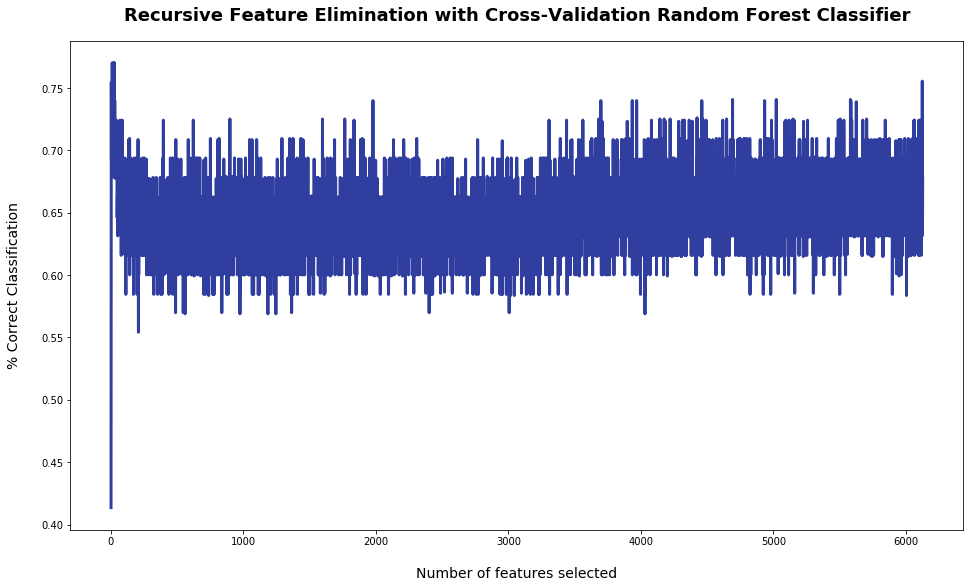

In [37]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation Random Forest Classifier', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [38]:
print(np.where(rfecv.support_ == False)[0])

X_RFC=X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_RFC

[    0     1     2 ... 12249 12250 12251]


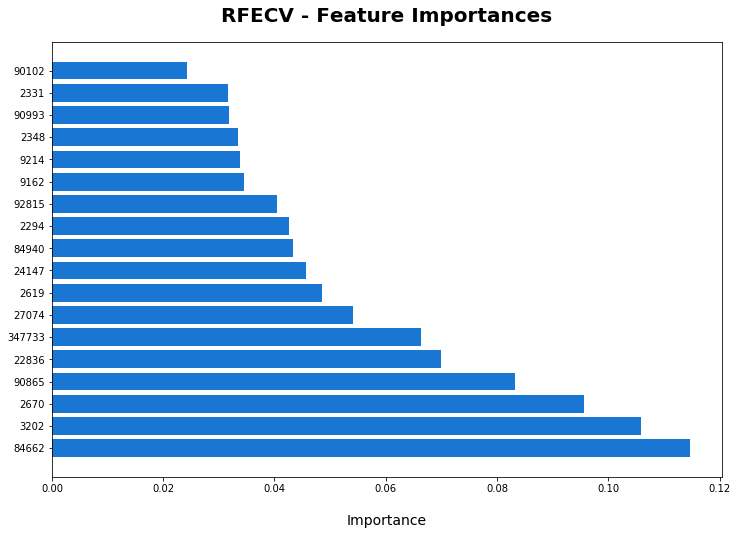

In [39]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(12, 8))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

## Test Train Split using Stratified shuffle split . 60/40

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.4, random_state=15)

for train_index,test_index in sss.split(X,y):
    X_train,X_test = X.loc[train_index] , X.loc[test_index]
    y_train,y_test = y.loc[train_index] , y.loc[test_index]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(39, 18) (39,)
(26, 18) (26,)


# Creating Classification Models

## Decision Tree Classifier

In [41]:
#Decision Tree Classifier
DTC = DecisionTreeClassifier(max_depth = 3, criterion='gini',random_state =15)
DTC.fit(X_train,y_train)
pred_test = DTC.predict(X_test)
pred_train= DTC.predict(X_train)
train_accuracy_DTC = accuracy_score(y_train,pred_train)
test_accuracy_DTC = accuracy_score(y_test,pred_test)
print("Train Accuracy of Decision Tree Classifier: {}".format(train_accuracy_DTC))

Train Accuracy of Decision Tree Classifier: 0.9487179487179487


In [42]:
print("Test Accuracy of Decision Tree Classifier: {}".format(test_accuracy_DTC))

Test Accuracy of Decision Tree Classifier: 0.6923076923076923


## Classification Report  and Model Accuracy

In [43]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.86      0.67      0.75         9
           2       0.83      0.71      0.77         7
           3       0.00      0.00      0.00         2

    accuracy                           0.69        26
   macro avg       0.58      0.56      0.56        26
weighted avg       0.72      0.69      0.69        26



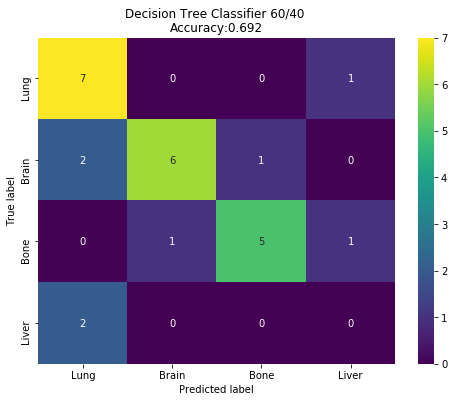

In [44]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver' ], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap='viridis')
plt.title('Decision Tree Classifier 60/40 \nAccuracy:{0:.3f}'.format(test_accuracy_DTC))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Random Forest Classifier

In [45]:
 #Random Forest Classifier
RFC = RandomForestClassifier(max_depth=3,criterion='gini' ,random_state=13)
RFC.fit(X_train,y_train)
pred_test = RFC.predict(X_test)
pred_train= RFC.predict(X_train)
train_accuracy_RFC = accuracy_score(y_train,pred_train)
test_accuracy_RFC = accuracy_score(y_test,pred_test)
print("Train Accuracy of Random Forest Classifier: {}".format(train_accuracy_RFC))

Train Accuracy of Random Forest Classifier: 1.0


In [46]:
print("Test Accuracy of Random Forest Classifier: {}".format(test_accuracy_RFC))

Test Accuracy of Random Forest Classifier: 0.8461538461538461


## Classification Report  and Model Accuracy

In [47]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.89      0.89      0.89         9
           2       0.75      0.86      0.80         7
           3       0.00      0.00      0.00         2

    accuracy                           0.85        26
   macro avg       0.63      0.69      0.66        26
weighted avg       0.78      0.85      0.81        26



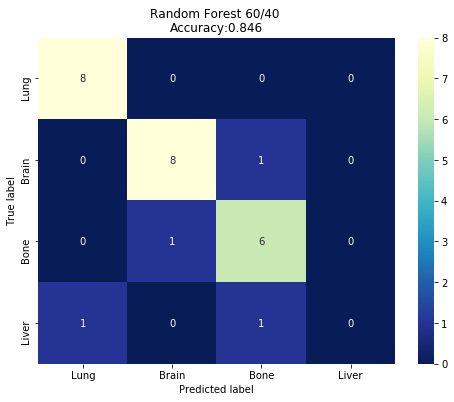

In [48]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver'], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap='YlGnBu_r')
plt.title('Random Forest 60/40 \nAccuracy:{0:.3f}'.format(test_accuracy_RFC))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## K Nearest Neighbor Classifier

In [49]:
 # KNN Classifier
KNN = KNeighborsClassifier(n_neighbors = 3, weights='uniform')
KNN.fit(X_train,y_train)
pred_test = KNN.predict(X_test)
pred_train= KNN.predict(X_train)
train_accuracy_KNN = accuracy_score(y_train,pred_train)
test_accuracy_KNN = accuracy_score(y_test,pred_test)
print("Train Accuracy of KNN Classifier: {}".format(train_accuracy_KNN))

Train Accuracy of KNN Classifier: 0.8717948717948718


In [50]:
print("Test Accuracy of KNN Classifier: {}".format(test_accuracy_KNN))

Test Accuracy of KNN Classifier: 0.9230769230769231


## Classification Report  and Model Accuracy

In [51]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      1.00      1.00         9
           2       0.88      1.00      0.93         7
           3       0.00      0.00      0.00         2

    accuracy                           0.92        26
   macro avg       0.69      0.75      0.72        26
weighted avg       0.86      0.92      0.89        26



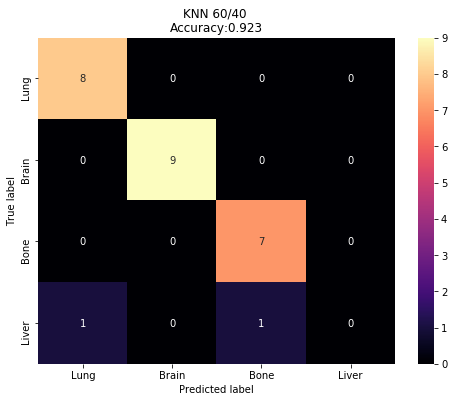

In [52]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver'], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap='magma')
plt.title('KNN 60/40 \nAccuracy:{0:.3f}'.format(test_accuracy_KNN))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## SVM Classifier

In [53]:
#SVC Support Vector Classifier
SVM = SVC(kernel = 'linear', C = 5)
SVM.fit(X_train, y_train)
pred_test  = SVM.predict(X_test)
pred_train = SVM.predict(X_train)
train_accuracy_SVM = accuracy_score(y_train,pred_train)
test_accuracy_SVM = accuracy_score(y_test,pred_test)
print("Train Accuracy of SVM: {}".format(train_accuracy_SVM))

Train Accuracy of SVM: 1.0


In [54]:
print("Test Accuracy of SVM Classifier: {}".format(test_accuracy_SVM))

Test Accuracy of SVM Classifier: 0.8461538461538461


## Classification Report  and Model Accuracy

In [55]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.78      0.88         9
           2       0.88      1.00      0.93         7
           3       0.00      0.00      0.00         2

    accuracy                           0.85        26
   macro avg       0.65      0.69      0.66        26
weighted avg       0.81      0.85      0.81        26



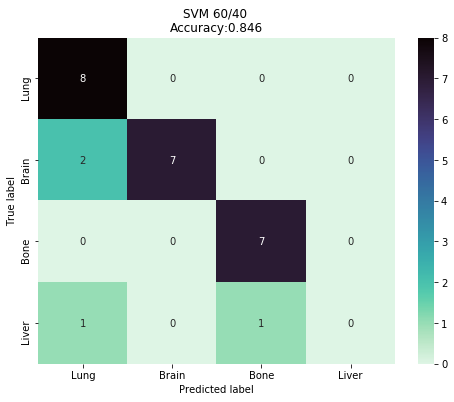

In [56]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver'], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap = 'mako_r')
plt.title('SVM 60/40 \nAccuracy:{0:.3f}'.format(test_accuracy_SVM))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## XGBoost Classifier

In [57]:
# XGB Classifier
XGB = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=13, eval_metric="auc", num_class=4)
XGB.fit(X_train, y_train) 
pred_test  = XGB.predict(X_test)
pred_train = XGB.predict(X_train)
train_accuracy_XGB = accuracy_score(y_train,pred_train)
test_accuracy_XGB = accuracy_score(y_test,pred_test)
print("Train Accuracy of XGBoost: {}".format(train_accuracy_XGB))

Train Accuracy of XGBoost: 1.0


In [58]:
print("Test Accuracy of XGBoost Classifier: {}".format(test_accuracy_XGB))

Test Accuracy of XGBoost Classifier: 0.8846153846153846


## Classification Report  and Model Accuracy

In [59]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      1.00      1.00         9
           2       0.86      0.86      0.86         7
           3       0.00      0.00      0.00         2

    accuracy                           0.88        26
   macro avg       0.69      0.71      0.70        26
weighted avg       0.85      0.88      0.87        26



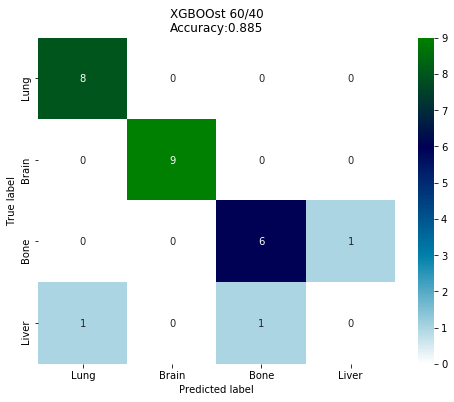

In [60]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver'], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap='ocean_r')
plt.title('XGBOOst 60/40\nAccuracy:{0:.3f}'.format(test_accuracy_XGB))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Comparison 

In [61]:
comparison={"Model":["Decision Tree Classifier", "Random Forest Classifier", "KNN Classifier", "SVM Classifier", "XGBoost Classifier"],
            "Test_Accuracy": [test_accuracy_DTC, test_accuracy_RFC, test_accuracy_KNN, test_accuracy_SVM, test_accuracy_XGB],
            "Train_Accuracy": [train_accuracy_DTC, train_accuracy_RFC, train_accuracy_KNN, train_accuracy_SVM, train_accuracy_XGB]
                   }
comparison = pd.DataFrame(comparison).sort_values('Test_Accuracy', ascending=False)
comparison

Model  Test_Accuracy  Train_Accuracy
2            KNN Classifier       0.923077        0.871795
4        XGBoost Classifier       0.884615        1.000000
1  Random Forest Classifier       0.846154        1.000000
3            SVM Classifier       0.846154        1.000000
0  Decision Tree Classifier       0.692308        0.948718

## Test Train Split using Stratified shuffle split . 70/30

In [62]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=15)

for train_index,test_index in sss.split(X,y):
    X_train,X_test = X.loc[train_index] , X.loc[test_index]
    y_train,y_test = y.loc[train_index] , y.loc[test_index]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(45, 18) (45,)
(20, 18) (20,)


# Creating Classification Models

## Decision Tree Classifier

In [63]:
#Decision Tree Classifier
DTC = DecisionTreeClassifier(max_depth = 3, criterion='gini',random_state =15)
DTC.fit(X_train,y_train)
pred_test = DTC.predict(X_test)
pred_train= DTC.predict(X_train)
train_accuracy_DTC = accuracy_score(y_train,pred_train)
test_accuracy_DTC = accuracy_score(y_test,pred_test)
print("Train Accuracy of Decision Tree Classifier: {}".format(train_accuracy_DTC))

Train Accuracy of Decision Tree Classifier: 0.9111111111111111


In [64]:
print("Test Accuracy of Decision Tree Classifier: {}".format(test_accuracy_DTC))

Test Accuracy of Decision Tree Classifier: 0.7


## Classification Report  and Model Accuracy

In [65]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.54      1.00      0.70         7
           2       1.00      0.40      0.57         5
           3       1.00      0.50      0.67         2

    accuracy                           0.70        20
   macro avg       0.88      0.64      0.68        20
weighted avg       0.84      0.70      0.69        20



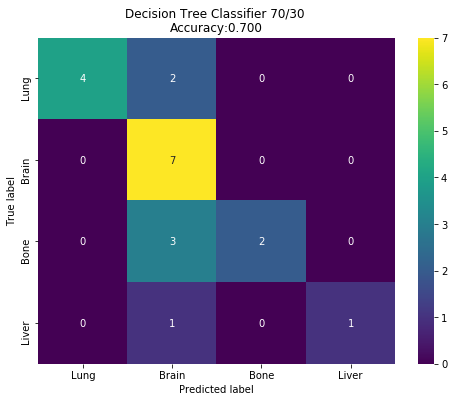

In [66]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver' ], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap='viridis')
plt.title('Decision Tree Classifier 70/30 \nAccuracy:{0:.3f}'.format(test_accuracy_DTC))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Random Forest Classifier

In [67]:
 #Random Forest Classifier
RFC = RandomForestClassifier(max_depth=3,criterion='gini' ,random_state=13)
RFC.fit(X_train,y_train)
pred_test = RFC.predict(X_test)
pred_train= RFC.predict(X_train)
train_accuracy_RFC = accuracy_score(y_train,pred_train)
test_accuracy_RFC = accuracy_score(y_test,pred_test)
print("Train Accuracy of Random Forest Classifier: {}".format(train_accuracy_RFC))

Train Accuracy of Random Forest Classifier: 0.9777777777777777


In [68]:
print("Test Accuracy of Random Forest Classifier: {}".format(test_accuracy_RFC))

Test Accuracy of Random Forest Classifier: 0.8


## Classification Report  and Model Accuracy

In [69]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.70      1.00      0.82         7
           2       1.00      0.80      0.89         5
           3       0.00      0.00      0.00         2

    accuracy                           0.80        20
   macro avg       0.63      0.66      0.64        20
weighted avg       0.74      0.80      0.76        20



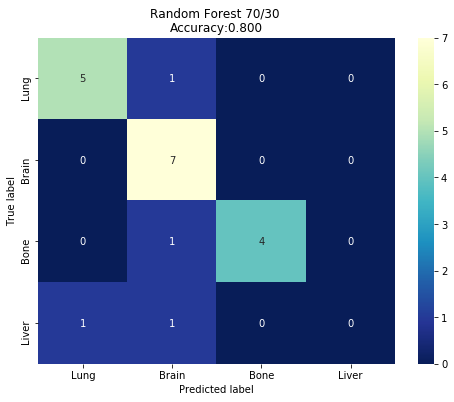

In [70]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver'], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap='YlGnBu_r')
plt.title('Random Forest 70/30 \nAccuracy:{0:.3f}'.format(test_accuracy_RFC))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## K Nearest Neighbor Classifier

In [71]:
 # KNN Classifier
KNN = KNeighborsClassifier(n_neighbors = 3, weights='uniform')
KNN.fit(X_train,y_train)
pred_test = KNN.predict(X_test)
pred_train= KNN.predict(X_train)
train_accuracy_KNN = accuracy_score(y_train,pred_train)
test_accuracy_KNN = accuracy_score(y_test,pred_test)
print("Train Accuracy of KNN Classifier: {}".format(train_accuracy_KNN))

Train Accuracy of KNN Classifier: 0.9777777777777777


In [72]:
print("Test Accuracy of KNN Classifier: {}".format(test_accuracy_KNN))

Test Accuracy of KNN Classifier: 0.8


## Classification Report  and Model Accuracy

In [73]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.86      0.86      0.86         7
           2       1.00      0.80      0.89         5
           3       0.33      0.50      0.40         2

    accuracy                           0.80        20
   macro avg       0.76      0.75      0.74        20
weighted avg       0.83      0.80      0.81        20



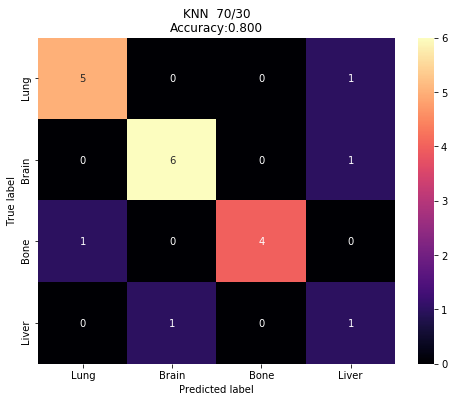

In [74]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver'], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap='magma')
plt.title('KNN  70/30\nAccuracy:{0:.3f}'.format(test_accuracy_KNN))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## SVM Classifier

In [75]:
#SVC Support Vector Classifier
SVM = SVC(kernel = 'linear', C = 5)
SVM.fit(X_train, y_train)
pred_test  = SVM.predict(X_test)
pred_train = SVM.predict(X_train)
train_accuracy_SVM = accuracy_score(y_train,pred_train)
test_accuracy_SVM = accuracy_score(y_test,pred_test)
print("Train Accuracy of SVM: {}".format(train_accuracy_SVM))

Train Accuracy of SVM: 1.0


In [76]:
print("Test Accuracy of SVM Classifier: {}".format(test_accuracy_SVM))

Test Accuracy of SVM Classifier: 0.8


## Classification Report  and Model Accuracy

In [77]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.78      1.00      0.88         7
           2       1.00      0.80      0.89         5
           3       0.33      0.50      0.40         2

    accuracy                           0.80        20
   macro avg       0.78      0.74      0.74        20
weighted avg       0.86      0.80      0.81        20



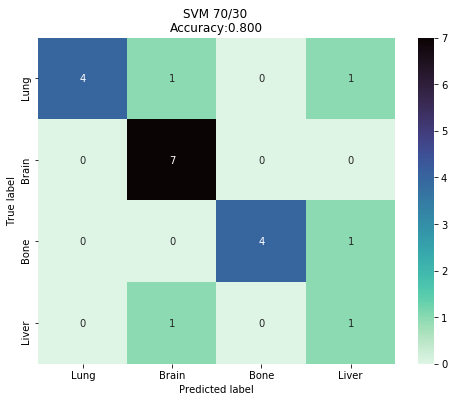

In [78]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver'], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap='mako_r')
plt.title('SVM 70/30 \nAccuracy:{0:.3f}'.format(test_accuracy_SVM))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## XGBoost Classifier

In [79]:
# XGB Classifier
XGB = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=13, eval_metric="auc", num_class=4)
XGB.fit(X_train, y_train) 
pred_test  = XGB.predict(X_test)
pred_train = XGB.predict(X_train)
train_accuracy_XGB = accuracy_score(y_train,pred_train)
test_accuracy_XGB = accuracy_score(y_test,pred_test)
print("Train Accuracy of XGBoost: {}".format(train_accuracy_XGB))

Train Accuracy of XGBoost: 1.0


In [80]:
print("Test Accuracy of XGBoost Classifier: {}".format(test_accuracy_XGB))

Test Accuracy of XGBoost Classifier: 0.8


## Classification Report  and Model Accuracy

In [81]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.70      1.00      0.82         7
           2       1.00      0.60      0.75         5
           3       0.50      0.50      0.50         2

    accuracy                           0.80        20
   macro avg       0.80      0.73      0.75        20
weighted avg       0.84      0.80      0.80        20



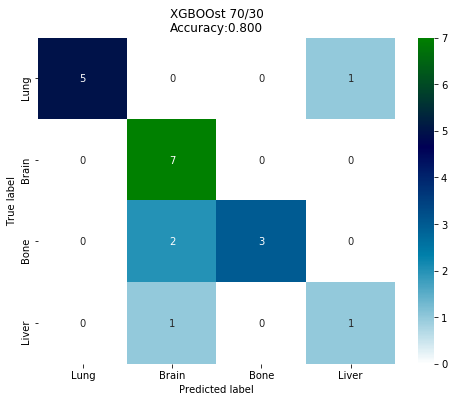

In [82]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver'], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap='ocean_r')
plt.title('XGBOOst 70/30\nAccuracy:{0:.3f}'.format(test_accuracy_XGB))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Comparison 

In [83]:
comparison={"Model":["Decision Tree Classifier", "Random Forest Classifier", "KNN Classifier", "SVM Classifier", "XGBoost Classifier"],
            "Test_Accuracy": [test_accuracy_DTC, test_accuracy_RFC, test_accuracy_KNN, test_accuracy_SVM, test_accuracy_XGB],
            "Train_Accuracy": [train_accuracy_DTC, train_accuracy_RFC, train_accuracy_KNN, train_accuracy_SVM, train_accuracy_XGB]
                   }
comparison = pd.DataFrame(comparison).sort_values('Test_Accuracy', ascending=False)
comparison

Model  Test_Accuracy  Train_Accuracy
1  Random Forest Classifier            0.8        0.977778
2            KNN Classifier            0.8        0.977778
3            SVM Classifier            0.8        1.000000
4        XGBoost Classifier            0.8        1.000000
0  Decision Tree Classifier            0.7        0.911111

## Test Train Split using Stratified shuffle split . 80/20

In [84]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=15)

for train_index,test_index in sss.split(X,y):
    X_train,X_test = X.loc[train_index] , X.loc[test_index]
    y_train,y_test = y.loc[train_index] , y.loc[test_index]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(52, 18) (52,)
(13, 18) (13,)


# Creating Classification Models

## Decision Tree Classifier

In [85]:
#Decision Tree Classifier
DTC = DecisionTreeClassifier(max_depth = 3, criterion='gini',random_state =15)
DTC.fit(X_train,y_train)
pred_test = DTC.predict(X_test)
pred_train= DTC.predict(X_train)
train_accuracy_DTC = accuracy_score(y_train,pred_train)
test_accuracy_DTC = accuracy_score(y_test,pred_test)
print("Train Accuracy of Decision Tree Classifier: {}".format(train_accuracy_DTC))

Train Accuracy of Decision Tree Classifier: 0.9615384615384616


In [86]:
print("Test Accuracy of Decision Tree Classifier: {}".format(test_accuracy_DTC))

Test Accuracy of Decision Tree Classifier: 0.3076923076923077


## Classification Report  and Model Accuracy

In [87]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.25      0.25      0.25         4
           1       0.50      0.50      0.50         4
           2       0.33      0.25      0.29         4
           3       0.00      0.00      0.00         1

    accuracy                           0.31        13
   macro avg       0.27      0.25      0.26        13
weighted avg       0.33      0.31      0.32        13



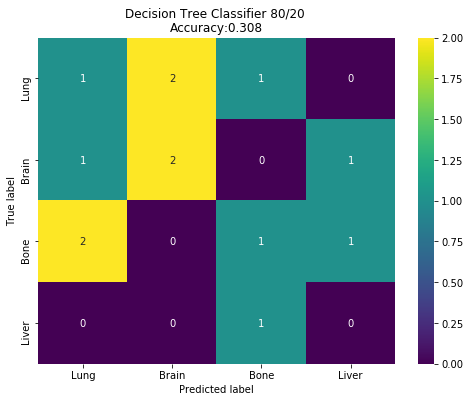

In [88]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver' ], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap='viridis')
plt.title('Decision Tree Classifier 80/20 \nAccuracy:{0:.3f}'.format(test_accuracy_DTC))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Random Forest Classifier

In [89]:
 #Random Forest Classifier
RFC = RandomForestClassifier(max_depth=3,criterion='gini' ,random_state=13)
RFC.fit(X_train,y_train)
pred_test = RFC.predict(X_test)
pred_train= RFC.predict(X_train)
train_accuracy_RFC = accuracy_score(y_train,pred_train)
test_accuracy_RFC = accuracy_score(y_test,pred_test)
print("Train Accuracy of Random Forest Classifier: {}".format(train_accuracy_RFC))

Train Accuracy of Random Forest Classifier: 1.0


In [90]:
print("Test Accuracy of Random Forest Classifier: {}".format(test_accuracy_RFC))

Test Accuracy of Random Forest Classifier: 0.8461538461538461


## Classification Report  and Model Accuracy

In [91]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.80      1.00      0.89         4
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         1

    accuracy                           0.85        13
   macro avg       0.65      0.69      0.66        13
weighted avg       0.80      0.85      0.81        13



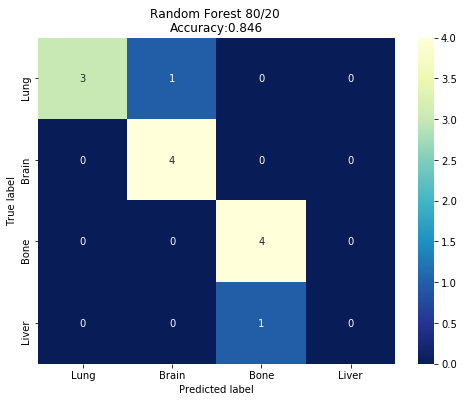

In [92]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver'], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap='YlGnBu_r')
plt.title('Random Forest 80/20 \nAccuracy:{0:.3f}'.format(test_accuracy_RFC))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## K Nearest Neighbor Classifier

In [93]:
 # KNN Classifier
KNN = KNeighborsClassifier(n_neighbors = 3, weights='uniform')
KNN.fit(X_train,y_train)
pred_test = KNN.predict(X_test)
pred_train= KNN.predict(X_train)
train_accuracy_KNN = accuracy_score(y_train,pred_train)
test_accuracy_KNN = accuracy_score(y_test,pred_test)
print("Train Accuracy of KNN Classifier: {}".format(train_accuracy_KNN))

Train Accuracy of KNN Classifier: 0.9423076923076923


In [94]:
print("Test Accuracy of KNN Classifier: {}".format(test_accuracy_KNN))

Test Accuracy of KNN Classifier: 0.9230769230769231


## Classification Report  and Model Accuracy

In [95]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         1

    accuracy                           0.92        13
   macro avg       0.70      0.75      0.72        13
weighted avg       0.86      0.92      0.89        13



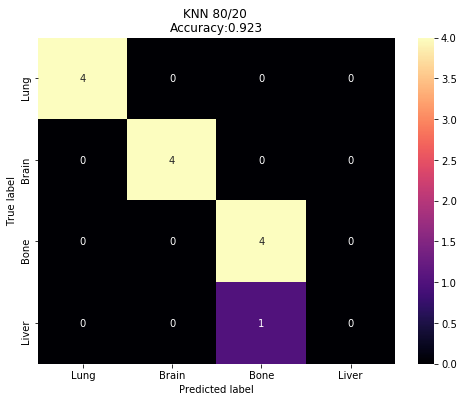

In [96]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver'], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap='magma')
plt.title('KNN 80/20 \nAccuracy:{0:.3f}'.format(test_accuracy_KNN))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [124]:
#Visualizers
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve

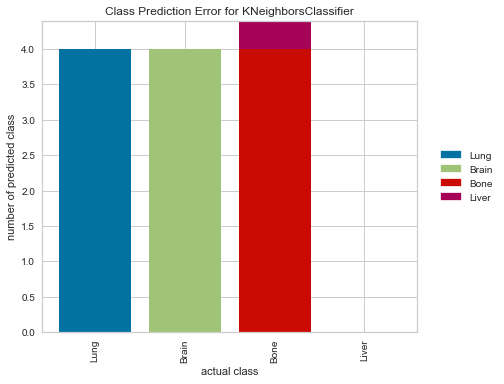

In [134]:
classes =['Lung','Brain','Bone','Liver']
model = KNN
visualizer = ClassPredictionError(model, classes=classes, support=True)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()
plt.show()

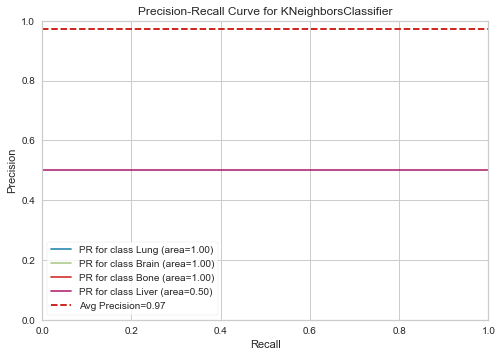

In [135]:
visualizer = PrecisionRecallCurve(model,classes=classes, per_class=True, iso_f1_curves=False,
fill_area=False, micro=False)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# Draw visualization
visualizer.show()
plt.show()

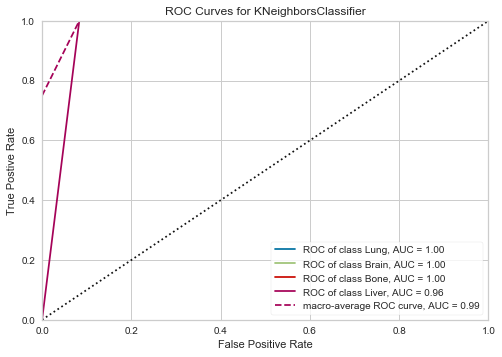

In [137]:
visualizer =ROCAUC(model,classes=classes, per_class=True, iso_f1_curves=False,
fill_area=False, micro=False)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# Draw visualization
visualizer.show()
plt.show()

## SVM Classifier

In [97]:
#SVC Support Vector Classifier
SVM = SVC(kernel = 'linear', C = 5)
SVM.fit(X_train, y_train)
pred_test  = SVM.predict(X_test)
pred_train = SVM.predict(X_train)
train_accuracy_SVM = accuracy_score(y_train,pred_train)
test_accuracy_SVM = accuracy_score(y_test,pred_test)
print("Train Accuracy of SVM: {}".format(train_accuracy_SVM))

Train Accuracy of SVM: 1.0


In [98]:
print("Test Accuracy of SVM Classifier: {}".format(test_accuracy_SVM))

Test Accuracy of SVM Classifier: 0.9230769230769231


## Classification Report  and Model Accuracy

In [99]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         1

    accuracy                           0.92        13
   macro avg       0.70      0.75      0.72        13
weighted avg       0.86      0.92      0.89        13



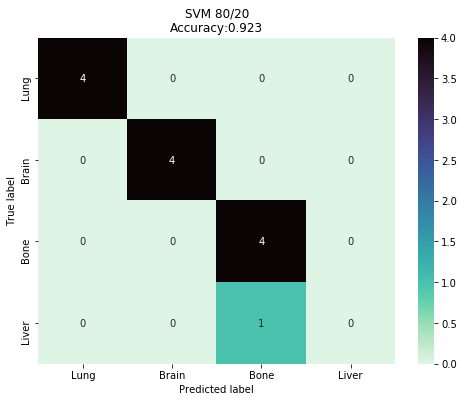

In [100]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver'], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap='mako_r')
plt.title('SVM 80/20\nAccuracy:{0:.3f}'.format(test_accuracy_SVM))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## XGBoost Classifier

In [101]:
# XGB Classifier
XGB = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=13, eval_metric="auc", num_class=4)
XGB.fit(X_train, y_train) 
pred_test  = XGB.predict(X_test)
pred_train = XGB.predict(X_train)
train_accuracy_XGB = accuracy_score(y_train,pred_train)
test_accuracy_XGB = accuracy_score(y_test,pred_test)
print("Train Accuracy of XGBoost: {}".format(train_accuracy_XGB))

Train Accuracy of XGBoost: 1.0


In [102]:
print("Test Accuracy of XGBoost Classifier: {}".format(test_accuracy_XGB))

Test Accuracy of XGBoost Classifier: 0.8461538461538461


## Classification Report  and Model Accuracy

In [103]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.80      1.00      0.89         4
           2       0.80      1.00      0.89         4
           3       0.00      0.00      0.00         1

    accuracy                           0.85        13
   macro avg       0.65      0.69      0.66        13
weighted avg       0.80      0.85      0.81        13



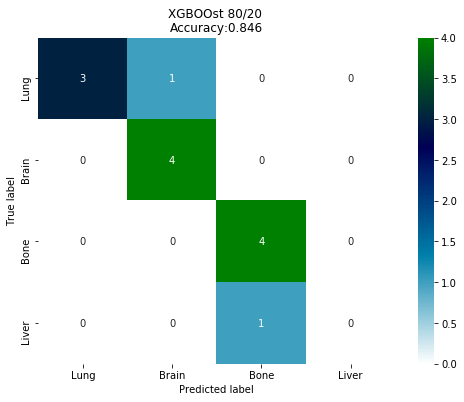

In [104]:
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Lung','Brain','Bone','Liver'], 
                     columns = ['Lung','Brain','Bone','Liver'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap='ocean_r')
plt.title('XGBOOst 80/20 \nAccuracy:{0:.3f}'.format(test_accuracy_XGB))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Comparison 

In [105]:
comparison={"Model":["Decision Tree Classifier", "Random Forest Classifier", "KNN Classifier", "SVM Classifier", "XGBoost Classifier"],
            "Test_Accuracy": [test_accuracy_DTC, test_accuracy_RFC, test_accuracy_KNN, test_accuracy_SVM, test_accuracy_XGB],
            "Train_Accuracy": [train_accuracy_DTC, train_accuracy_RFC, train_accuracy_KNN, train_accuracy_SVM, train_accuracy_XGB]
                   }
comparison = pd.DataFrame(comparison).sort_values('Test_Accuracy', ascending=False)
comparison

Model  Test_Accuracy  Train_Accuracy
2            KNN Classifier       0.923077        0.942308
3            SVM Classifier       0.923077        1.000000
1  Random Forest Classifier       0.846154        1.000000
4        XGBoost Classifier       0.846154        1.000000
0  Decision Tree Classifier       0.307692        0.961538

In [110]:
#Visualizers
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve

In [128]:
classes =['Lung','Brain','Bone','Liver']
classes

['Lung', 'Brain', 'Bone', 'Liver']

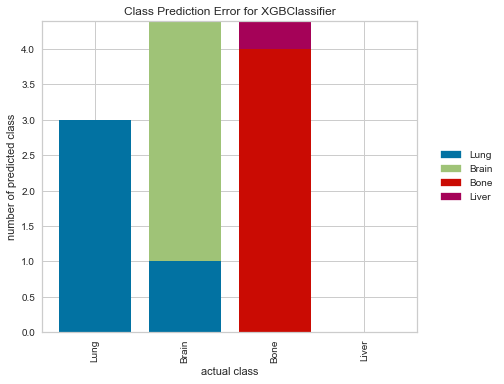

In [129]:
model = XGB
visualizer = ClassPredictionError(model, classes=classes, support=True)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

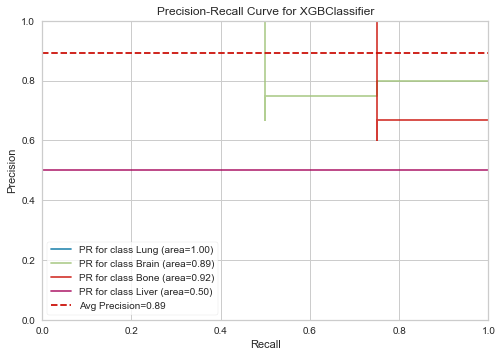

In [130]:
visualizer = PrecisionRecallCurve(model,classes=classes, per_class=True, iso_f1_curves=False,
fill_area=False, micro=False)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# Draw visualization
visualizer.show()

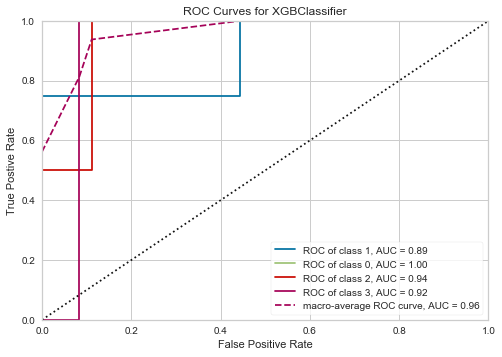

In [119]:
visualizer =ROCAUC(model,classes=classes, per_class=True, iso_f1_curves=False,
fill_area=False, micro=False)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# Draw visualization
visualizer.show()

